<div align="center">
    
# 프로젝트: Self-Supervised Learning을 통한 자동차 부위 사진 Clustering
    
</div>

<br>
<br>

**라이브러리 버전 확인**

---

In [12]:
import torch
import torchvision
import matplotlib
import cv2
import seaborn 
import sklearn
import matplotlib
import PIL

print(torch.__version__)
print(torchvision.__version__)
print(matplotlib.__version__)
print(cv2.__version__)
print(seaborn.__version__)
print(sklearn.__version__)
print(matplotlib.__version__)
print(PIL.__version__)

1.9.1+cu111
0.10.1+cu111
3.4.3
4.5.3
0.11.2
1.0
3.4.3
8.3.2



<br>

### 1. 쏘카 자동차 외관 이미지 파악하기

---

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import PIL.Image as Image
import shutil

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import sklearn
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

device = 'cuda:0'

분석 대상 이미지들의 개수:  1446


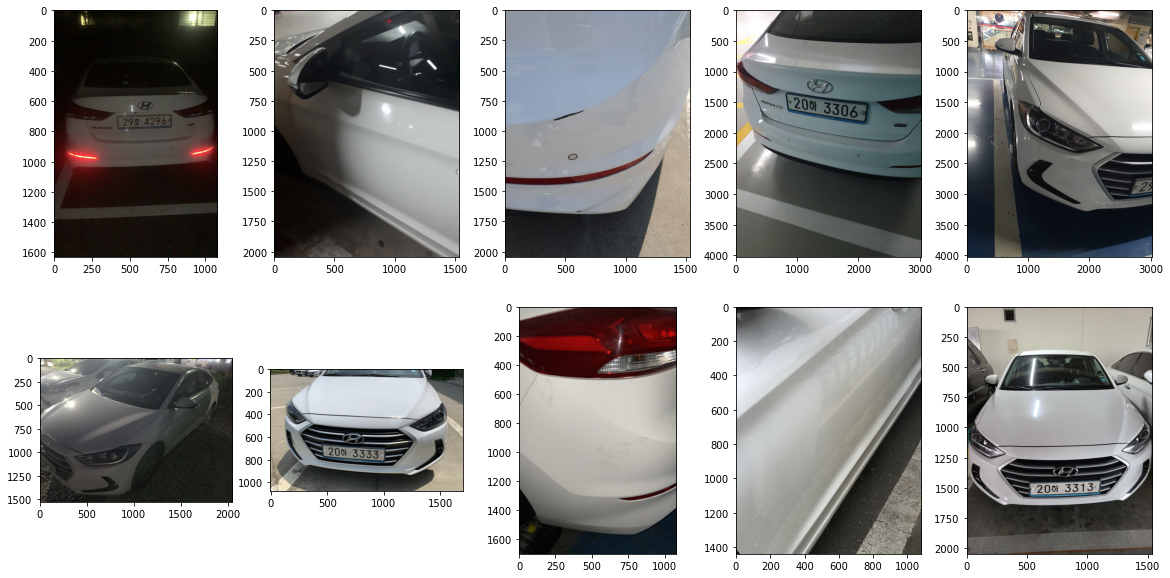

In [14]:
img_path = os.path.join(os.getenv('HOME') , 'aiffel/socar_clustering/data/images/avante_images')
print('분석 대상 이미지들의 개수: ', len(os.listdir(img_path)))

fig = plt.figure(figsize=(20, 10))
columns = 5
rows = 2
for i in range(1, columns*rows +1):  # 샘플 10개 이미지만 골라서

    filename = os.listdir(img_path)[i]
    filepath = os.path.join(img_path, filename) # 파일 이름으로 읽고
    img = cv2.imread(filepath)[:,:,::-1] # 이미지로 읽은 후에 -> RGB 채널을 순서를 변경해주고

    fig.add_subplot(rows, columns, i)
    plt.imshow(img)# 이미지를 plotting 합니다
plt.show()

In [15]:
sample_path = img_path + '/2865.jpg' # path를 정의하고
sample_img = cv2.imread(sample_path) # opencv-python을 이용해서 이미지를 읽고

print(type(sample_img)) # nd.array 형태의
print(sample_img.shape) # height 1633 x width 1080 x channel 3 짜리 이미지가 나왔습니다

<class 'numpy.ndarray'>
(1633, 1080, 3)


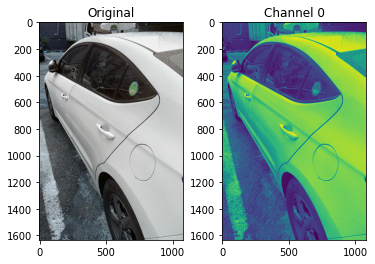

In [16]:
plt.subplot(1,2,1)
plt.title('Original')
plt.imshow(sample_img)

plt.subplot(1,2,2)
plt.title('Channel 0')
channel_img = sample_img[:,:,0] # 0번째 채널 이미지
plt.imshow(channel_img)

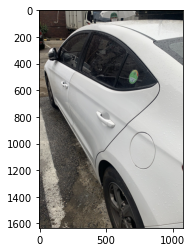

In [17]:
sample_img_rgb = sample_img[:,:,::-1] #모든 채널을 담은 이미지 
plt.imshow(sample_img_rgb)

In [18]:
from PIL import Image

img = Image.fromarray(np.uint8(sample_img_rgb))

/opt/conda/lib/python3.9/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


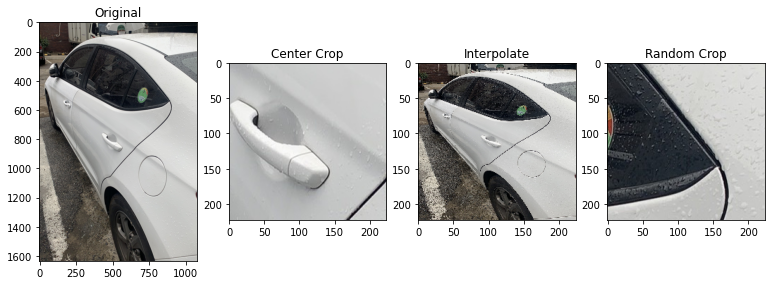

In [19]:
from torchvision import datasets, transforms

center_cropper = transforms.Compose([
    transforms.CenterCrop((224,224)),
])

interpolater = transforms.Compose([
    transforms.Resize((224,224), interpolation=Image.NEAREST)
])

random_cropper = transforms.Compose([
    transforms.RandomCrop((224,224))
])

center_crop = center_cropper(img)
interpolate = interpolater(img)
random_crop = random_cropper(img)

plt.figure(figsize=(13,5))
plt.subplot(1,4,1)
plt.title('Original')
plt.imshow(img)

plt.subplot(1,4,2)
plt.title('Center Crop')
plt.imshow(center_crop)

plt.subplot(1,4,3)
plt.title('Interpolate')
plt.imshow(interpolate)

plt.subplot(1,4,4)
plt.title('Random Crop')
plt.imshow(random_crop)

### 2. ImageNet-weight를 탑재한 VGG-16로 Representation Vector 뽑아보기.

---
torchvision의 [VGG-16](https://pytorch.org/vision/stable/models.html)을 이용해서 Representation Vector를 추출.

In [20]:
model = torchvision.models.vgg16(pretrained=True).to(device)
features = list(model.features)

In [21]:
features

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1

### 3. ImageNet-weight로 추출한 Representation Vector로 이미지 Clustering 해보기

---
VGG16에 ImageNet 가중치를 불러와 Representation Vector를 추출하고 clustering한다.

In [22]:
data_transforms = transforms.Compose([
    transforms.Resize((224,224), interpolation=Image.NEAREST),   # image resize
    transforms.ToTensor(),   # tensor로 변환
])

# Dataloader 생성
def create_dataloader(path):
    
    # torch dataset으로 wrapping
    target_datasets = datasets.ImageFolder(path, transform=data_transforms)
    
    # dataloader로 wrapping return
    dataloader = torch.utils.data.DataLoader(
        target_datasets,
        shuffle=False
    )
    
    return dataloader

In [23]:
dataloader = create_dataloader(os.getenv('HOME')+'/aiffel/socar_clustering/data/images')

In [24]:
def provide_representations_sample(model, dataloader, size):

    representations = list()
    filenames = list()
    model.eval()

    for idx, (inputs, labels) in enumerate(dataloader):

        inputs = inputs.to(device)
   
        outputs =  model.features(inputs)
        outputs = outputs.cpu().detach().numpy()
        outputs = outputs.reshape(outputs.shape[0],-1)
        
        filename, _ = dataloader.dataset.samples[idx]

        representations.append(outputs)
        filenames.append(filename)
        
        if idx > size-2 : 
            break

    representations = np.asarray(representations) # N x 1 x ?
    representations = np.squeeze(representations , axis=1) # dimension을 하나 줄임. N x ?
    
    filenames = np.asarray(filenames)
    
    return representations, filenames

In [25]:
representations, filenames = provide_representations_sample(model, dataloader,1000)
print('Representation Shape: ', representations.shape)

Representation Shape:  (1000, 25088)


In [26]:
target_cluster_num = 6
kmeans = KMeans(n_clusters=target_cluster_num, random_state=0).fit(representations)

cluster_label = kmeans.predict(representations)


cluster  0


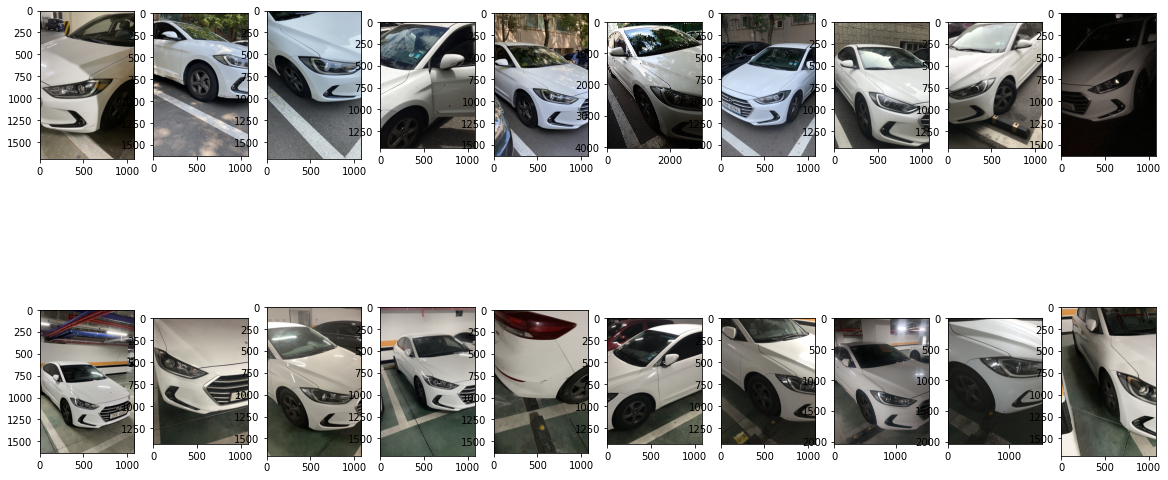

cluster  1


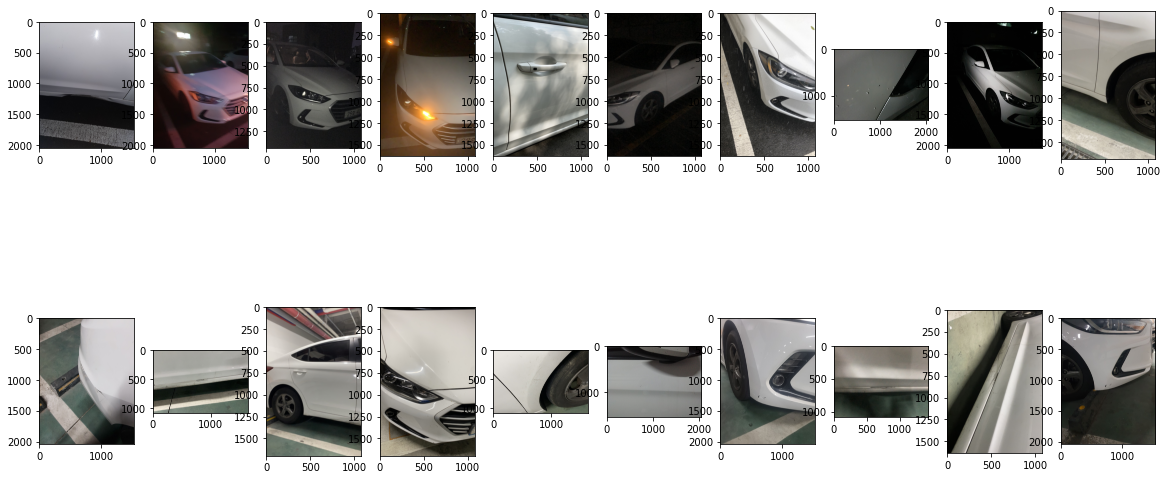

cluster  2


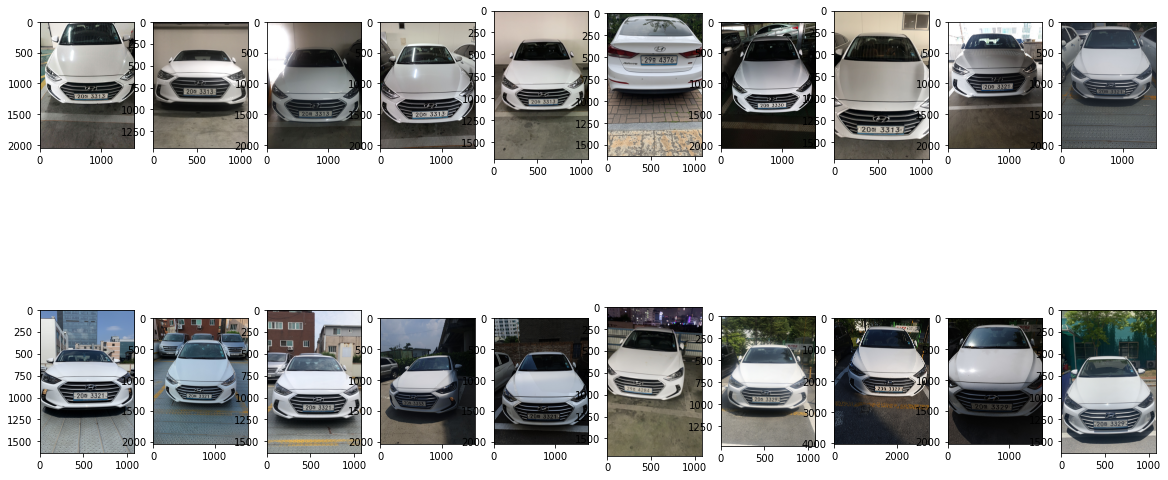

cluster  3


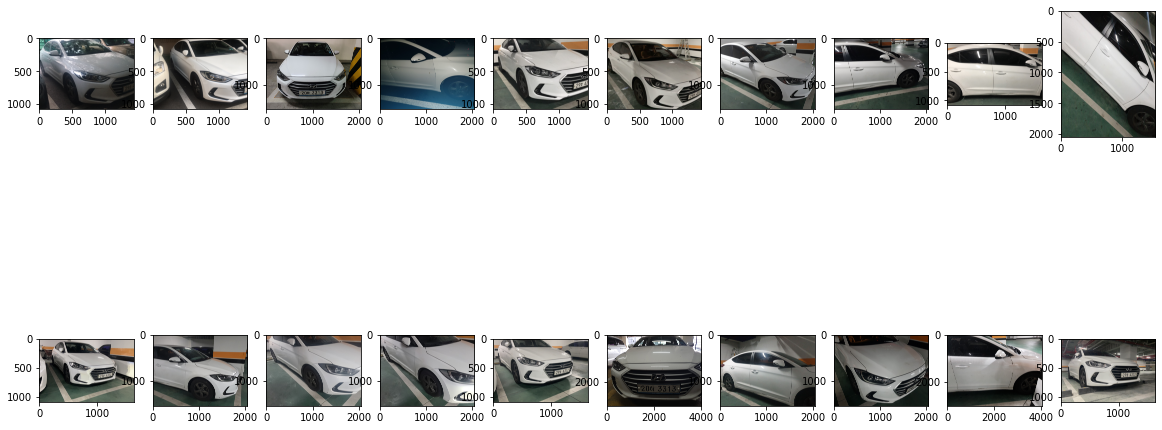

cluster  4


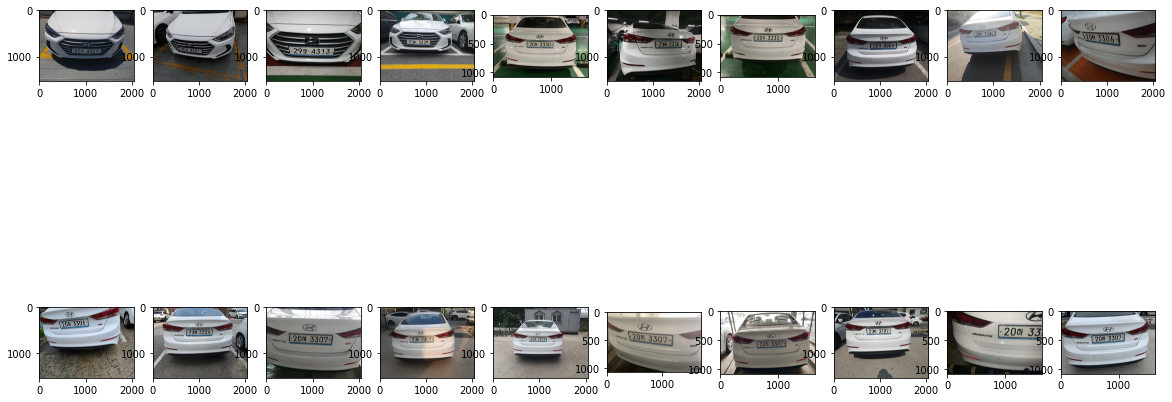

cluster  5


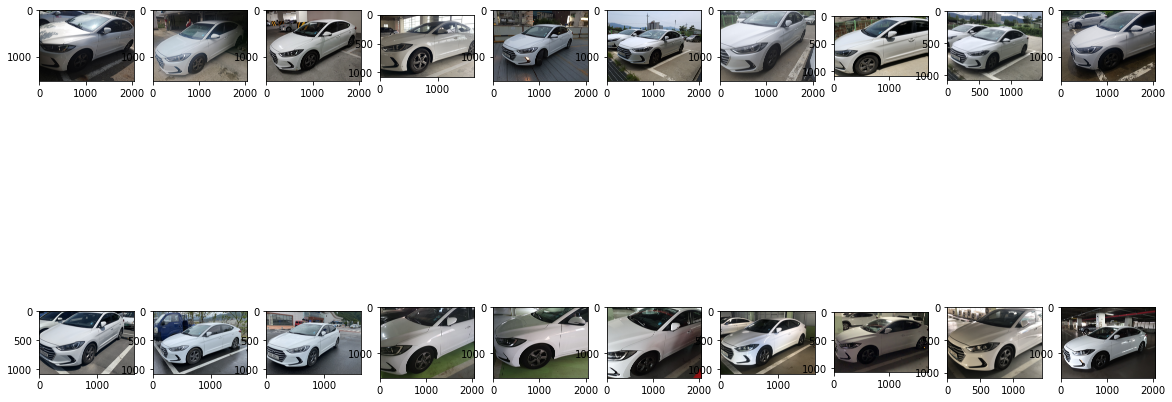

In [27]:
for id in range(6) :
    print("cluster ", id)
    print("="*50)
    selected_idxes = cluster_label==id
    selected_filenames = filenames[selected_idxes]

    fig = plt.figure(figsize=(20, 10))
    columns = 10
    rows = 2
    for i in range(1, columns*rows +1):  # 샘플 10개 이미지만 골라서
        try:
            filepath = selected_filenames[i]
            img = cv2.imread(filepath)[:,:,::-1] # 이미지로 읽은 후에 -> RGB 채널을 순서를 변경해주고

            fig.add_subplot(rows, columns, i)
            plt.imshow(img)# 이미지를 plotting 합니다.
        except:
            pass
    plt.show()

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


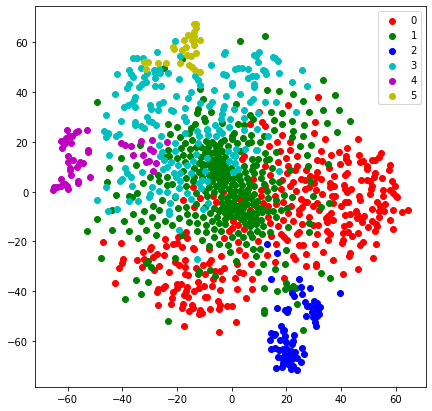

In [28]:
#colored by k-means cluster
x_embedded = TSNE(n_components=2).fit_transform(representations)
target_ids = range(0,6)


plt.figure(figsize=(7, 7))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'pink', 'orange', 'purple', 'olive', 'lime', 'palevioletred','teal', 'papayawhip', 'thistle', 'slategray', 'darkseagreen', 'salmon', 'rebeccapurple', 'beige'

for i, c, label in zip(target_ids, colors, target_ids):
    plt.scatter(x_embedded[cluster_label == i, 0], x_embedded[cluster_label == i, 1], c=c, label=label)
plt.legend()
plt.show()

### 4. Self-Supervised Learning 기법 중 Rotation Prediction 구현해보기

---
Rotation Prediction 기법으로 구현

In [29]:
def create_rotnet_set(base_dir, self_train_size, self_test_size):
    
    # Candidate Train, Test Filename 추출
    candidate_train_filenames, candidate_test_filenames = \
    path_to_train_test_filenames(base_dir, self_train_size, self_test_size)
    
    # Rotation 수행
    print('>> Start Making a Rotated Set...')
    save_base = os.path.join(base_dir, 'self_dataset', 'train_size_' + str(self_train_size))
    
    print('> Start Rotating Training Set...')
    train_save_dir = os.path.join(save_base, 'Training')
    if not os.path.exists(train_save_dir):
        os.makedirs(train_save_dir)
    rotate_and_save(candidate_train_filenames, train_save_dir)
        
    print('> Start Rotating Test Set...')
    test_save_dir = os.path.join(save_base, 'Test')
    if not os.path.exists(test_save_dir):
        os.makedirs(test_save_dir)
    rotate_and_save(candidate_test_filenames, test_save_dir)


In [30]:
def path_to_train_test_filenames(base_dir, self_train_size, self_test_size):
    candidate_train_filenames = list()
    candidate_test_filenames = list()
    
    # 각 Class 별로 파일 이름 모으고
    target_src_path = os.path.join(base_dir, 'images')
    print('>>>>>>', target_src_path)
    print(os.listdir(target_src_path))
    
    for class_name in sorted(os.listdir(target_src_path)):
        
        class_path = os.path.join(target_src_path, class_name)
        class_test_filenames = sorted(os.listdir(class_path))[:self_test_size]
        class_train_filenames = sorted(os.listdir(class_path))[self_test_size : self_test_size+self_train_size]
        
        for class_filename in class_test_filenames:
            class_filepath = os.path.join(class_path, class_filename)
            candidate_test_filenames.append(class_filepath)
        
        for class_filename in class_train_filenames:
            class_filepath = os.path.join(class_path, class_filename)
            candidate_train_filenames.append(class_filepath)
            
    print('Train for Self: ', len(candidate_train_filenames))            
    print('Test for Self: ', len(candidate_test_filenames))
    
    return candidate_train_filenames, candidate_test_filenames

In [31]:
def rotate_and_save(src_filenames, save_dir):
    rotation_list = [0, 90, 180, 270]
        
    for rotation_degree in rotation_list:
        print('> working on degree '+ str(rotation_degree))
        
        rot_save_dir = os.path.join(save_dir, 'degree_' + str(rotation_degree))
        if not os.path.exists(rot_save_dir):
            os.makedirs(rot_save_dir)

        for src_filename in src_filenames:

            img = cv2.imread(src_filename)
            rotated_img = image_rotator(img, rotation_degree)
    
            cv2.imwrite(os.path.join(rot_save_dir, src_filename.split('/')[-1]), rotated_img)


In [32]:
def image_rotator(img, rotate_type):
    
    if rotate_type == 0:
        rotated_img = img
    
    elif rotate_type == 90:
        rotated_img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        
    elif rotate_type == 180:
        rotated_img = cv2.rotate(img, cv2.ROTATE_180)
        
    elif rotate_type == 270:
        rotated_img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
        
    else:
        raise ValueError

    return rotated_img


In [33]:
# Self Supervised Learning 학습을 위한 Training / Test Set 생성하기
self_dataset_path = os.getenv('HOME')+'/aiffel/socar_clustering/data/'
self_train_size = 1100
self_test_size = 346

create_rotnet_set(self_dataset_path, self_train_size, self_test_size)

>>>>>> /aiffel/aiffel/socar_clustering/data/images
['avante_images']
Train for Self:  1100
Test for Self:  346
>> Start Making a Rotated Set...
> Start Rotating Training Set...
> working on degree 0
> working on degree 90
> working on degree 180
> working on degree 270
> Start Rotating Test Set...
> working on degree 0
> working on degree 90
> working on degree 180
> working on degree 270


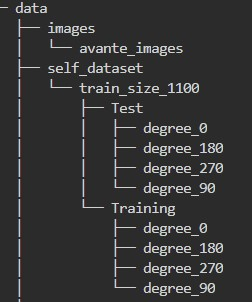

In [34]:
# dataloader를 이용한 wrapping

train_dir = os.getenv('HOME')+'/aiffel/socar_clustering/data/self_dataset/train_size_'+str(self_train_size)+'/Training'
test_dir = os.getenv('HOME')+'/aiffel/socar_clustering/data/self_dataset/train_size_'+str(self_train_size)+'/Test'

data_transforms = transforms.Compose([
    transforms.Resize((224,224), interpolation=Image.NEAREST),
    transforms.ToTensor(),
])

train_datasets = datasets.ImageFolder(train_dir, transform=data_transforms)
train_loaders = torch.utils.data.DataLoader(
    train_datasets,
    batch_size=4,
    shuffle=True,
)

test_datasets = datasets.ImageFolder(test_dir, transform=data_transforms)
test_loaders = torch.utils.data.DataLoader(
    test_datasets,
    shuffle=True,
)

dataloaders = {
    'train':train_loaders,
    'test':test_loaders
}

/opt/conda/lib/python3.9/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [35]:
pretext_model = torchvision.models.vgg16()
pretext_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [36]:
# Rotation Prediction 신경망 구성
pretext_model._fc = nn.Linear(4096, 4)
pretext_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pretext_model.parameters(), lr=0.01)

1에포크 당 2시간 정도 걸리므로 신경망 까지만 구성하고 아래 코드는 작동시키지 않겠습니다.

In [ ]:
num_epochs=20
model = pretext_model

train_acc_list =[]
train_loss_list = []
test_acc_list = []
test_loss_list = []


since = time.time()

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 20)

    # Each epoch has a training and validation phase
    for phase in ['train', 'test']:
        
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # print(labels)
            # print(labels.shape)
            # break
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
        
        print('>> Phase: ', phase)
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))

        if phase == 'train':
            train_acc_list.append(epoch_acc)
            train_loss_list.append(epoch_loss)
        else:
            test_acc_list.append(epoch_acc)
            test_loss_list.append(epoch_loss)
            
        # deep copy the model
        if phase == 'test' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())


time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best test Acc: {:4f}'.format(best_acc))

# load best model weights
# model.load_state_dict(best_model_wts)
models_dir = os.getenv('HOME')+'/aiffel/socar_clustering/data/models/'
torch.save(best_model_wts , models_dir + 'pretrained_vgg.pt')

loss accuracy 그래프 시각화

In [ ]:
from matplotlib import pyplot as plt
plt.plot(train_loss_list)
plt.plot(test_loss_list)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(train_acc_list)
plt.plot(test_acc_list)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### 5. Self-Supervised Weight를 이용해 Representation Vector를 뽑고, Clustering 해보기

---
이미지 1,446장을 가지고 100 epoch 학습시킨 모델을 제공해 드리도록 하겠습니다. 직접 학습시키기 어려운 분들은 해당 모델을 사용해 주세요.

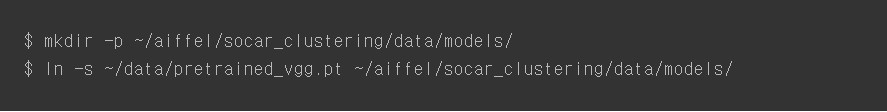

In [37]:
final_model = torchvision.models.vgg16()

In [38]:
final_model.features = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
    nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.ReLU(inplace=True),
    nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
    nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
    nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
    nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
  )


In [39]:
final_model.classifier = nn.Sequential(
nn.Linear(512 * 7 * 7, 4096),
nn.ReLU(True),
nn.Dropout(p=0.5),
nn.Linear(4096, 4096),
nn.ReLU(True),
nn.Dropout(p=0.5),
nn.Linear(4096, 4),
)

In [40]:
# Representation Vector 추출하고, Clustering 다시 수행
final_model.load_state_dict(torch.load(os.getenv('HOME')+'/aiffel/socar_clustering/data/models/pretrained_vgg.pt', map_location=device))
final_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [41]:
# model, dataloader를 input으로 제공한 이후, representation vector를 추출합니다
def provide_representations_sample(model, dataloader, size):

    representations = list()
    filenames = list()
    model.eval()

    for idx, (inputs, labels) in enumerate(dataloader):

        inputs = inputs.to(device)
        # outputs = model(inputs)
        outputs =  model.features(inputs)
        outputs = outputs.cpu().detach().numpy()
        outputs = outputs.reshape(outputs.shape[0],-1)
        
        filename, _ = dataloader.dataset.samples[idx]

        representations.append(outputs)
        filenames.append(filename)
        
        if idx > size-2 : 
            break

    representations = np.asarray(representations) # N x 1 x ?
    representations = np.squeeze(representations , axis=1) # dimension을 하나 줄여주고 -> N x ?
    
    filenames = np.asarray(filenames)
    
    return representations, filenames


In [42]:
final_representations, filenames = provide_representations_sample(final_model, dataloader, 1000)
print(final_representations.shape)
print(filenames.shape)

(1000, 25088)
(1000,)


In [43]:
#  Clustering 해보기

target_cluster_num = 6
final_kmeans = KMeans(n_clusters=target_cluster_num, random_state=0).fit(final_representations)

final_cluster_label = final_kmeans.predict(final_representations)

cluster  0


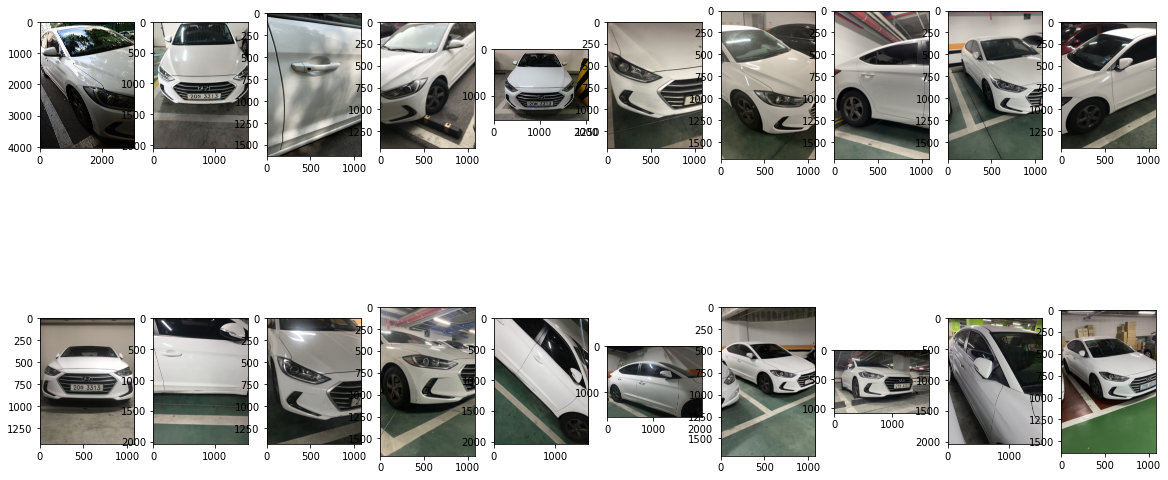

cluster  1


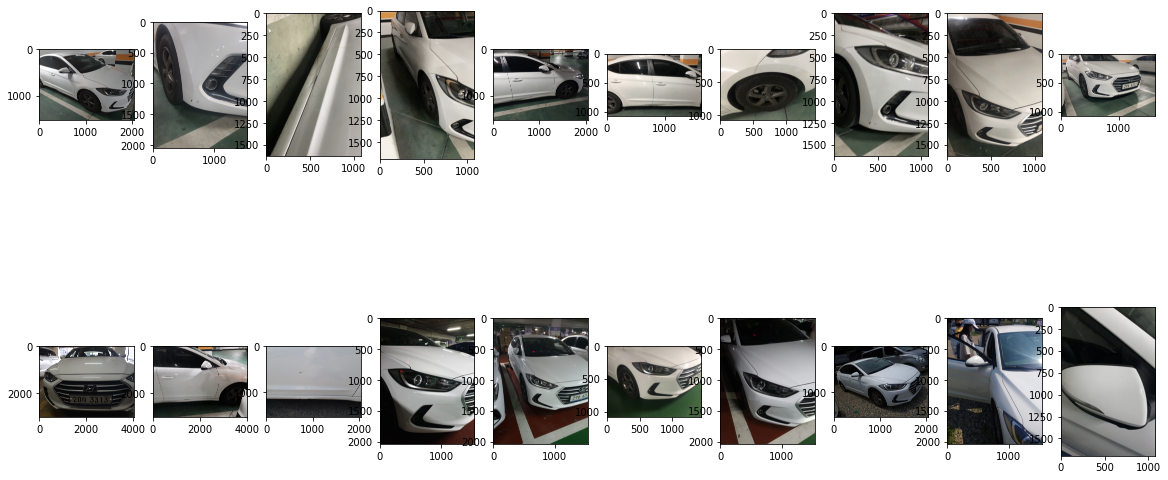

cluster  2


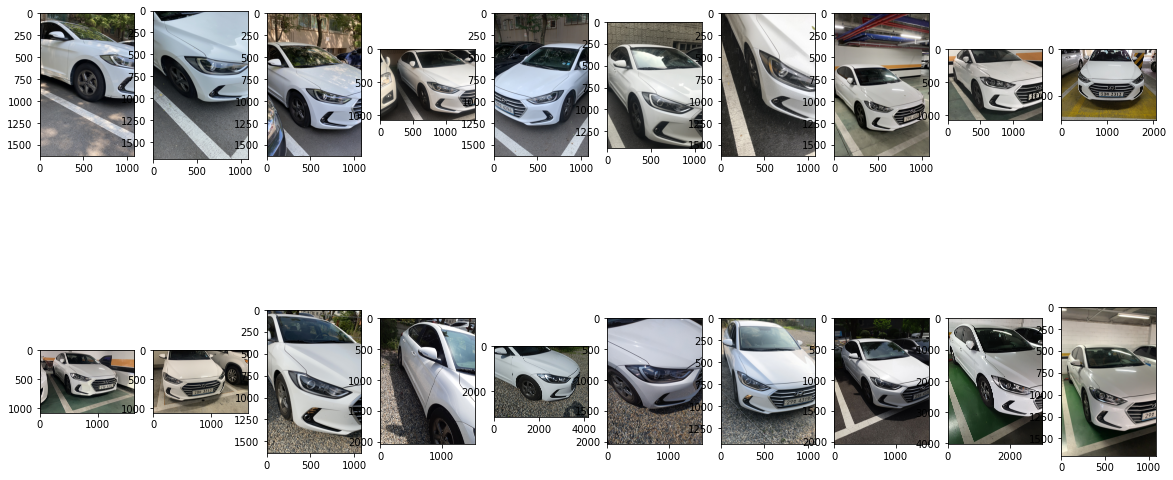

cluster  3


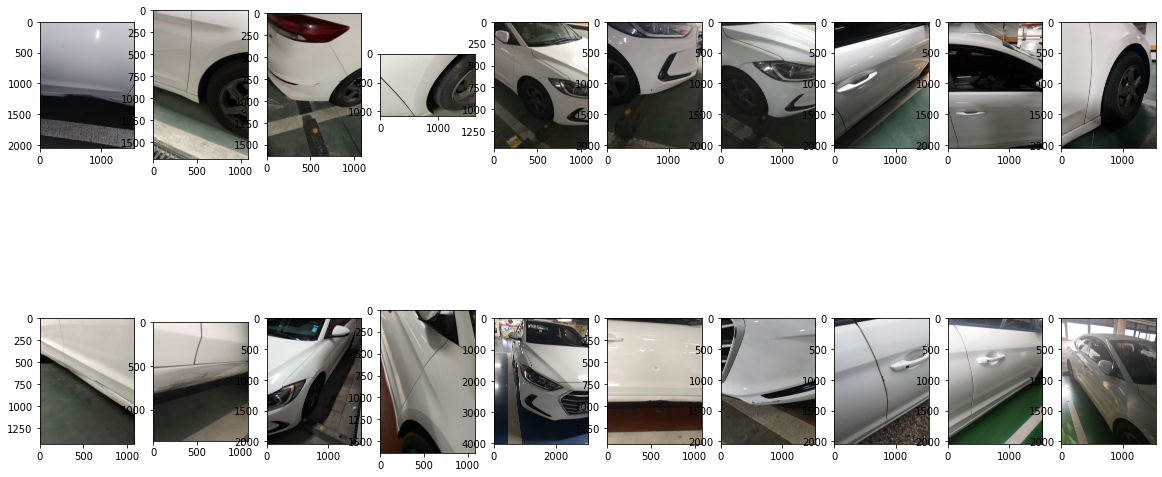

cluster  4


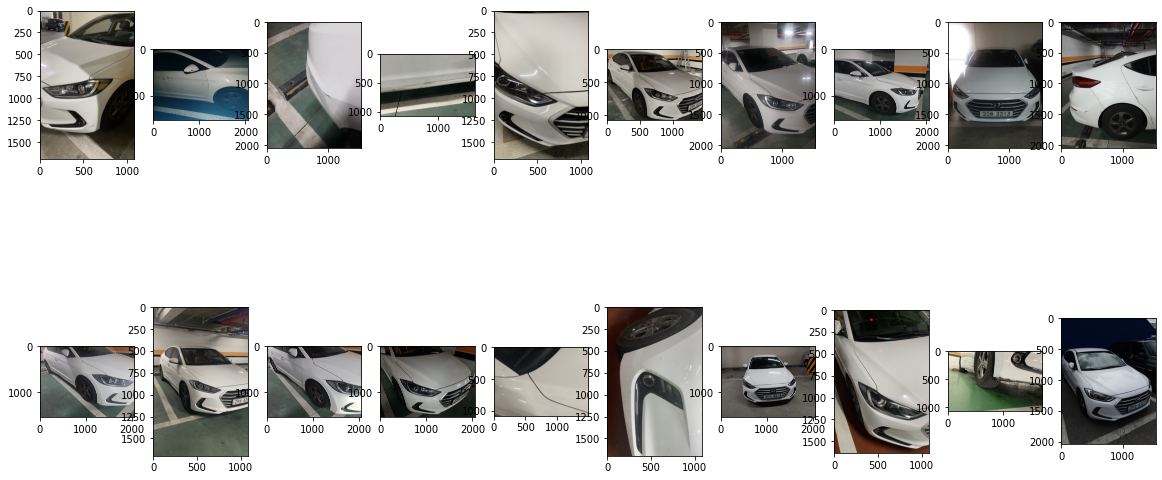

cluster  5


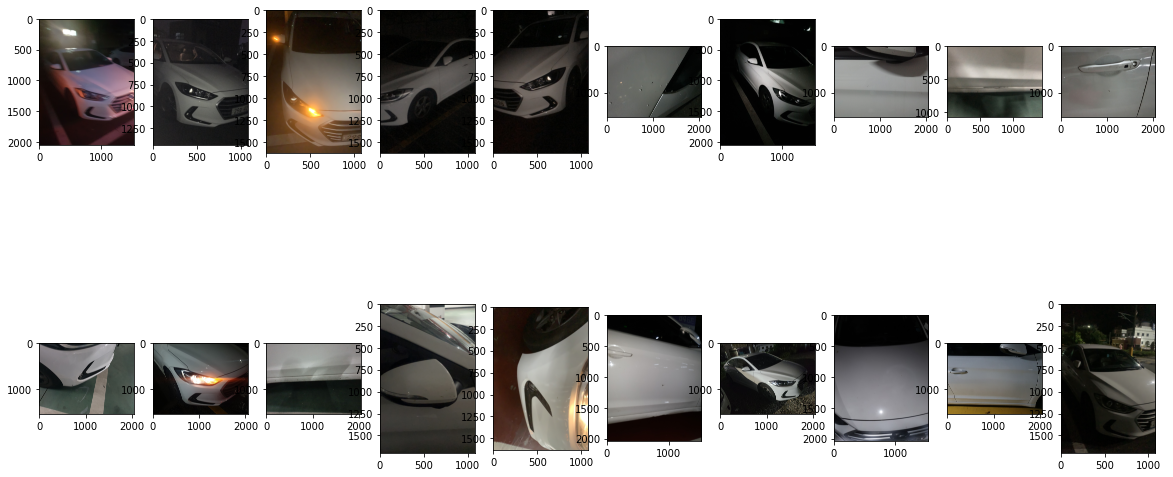

In [44]:
for id in range(6) : 
    print("cluster ", id)
    print("="*100)
    final_selected_idxes = final_cluster_label==id
    final_selected_filenames = filenames[final_selected_idxes]

    fig = plt.figure(figsize=(20, 10))
    columns = 10
    rows = 2
    for i in range(1, columns*rows +1):  # 샘플 10개 이미지만 골라서
        try :
            filepath = final_selected_filenames[i]
            img = cv2.imread(filepath)[:,:,::-1] # 이미지로 읽은 후에 -> RGB 채널을 순서를 변경해주고

            fig.add_subplot(rows, columns, i)
            plt.imshow(img)# 이미지를 plotting 합니다
        except : 
            pass
    plt.show()

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


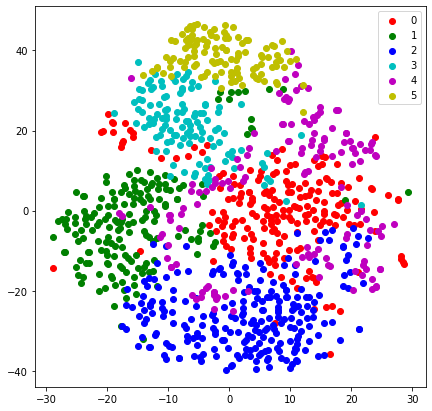

In [45]:
# T-SNE로 차원축소해서 이미지들 사이의 representation에 차이가 있는지 확인해본다
x_embedded_final = TSNE(n_components=2).fit_transform(final_representations)

target_ids = range(0,6)

plt.figure(figsize=(7, 7))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'pink', 'orange', 'purple', 'olive', 'lime', 'palevioletred','teal', 'papayawhip', 'thistle', 'slategray', 'darkseagreen', 'salmon', 'rebeccapurple', 'beige'
for i, c, label in zip(target_ids, colors, target_ids):
    plt.scatter(x_embedded_final [final_cluster_label == i, 0], x_embedded_final[final_cluster_label == i, 1], c=c, label=label)
plt.legend()
plt.show()

### 6. ImageNet-weight와 Self-Supervised weight로 만든 Cluster 비교해보기

---
실습에서는 `CIFAR-10`의 `raw data`로 `clustering`한 것, `ImageNet-weight`로 `clustering` 한 것, `Self-Supervised weight`로 `clustering`한 것을 직접 클러스터에 할당된 이미지로 ploting 하고 T-SNE를 이용하여 시각화 함으로써 비교해 보았습니다. 이번에는 clustering 실루엣 스코어를 이용하여 정량적으로 평가를 진행해 보도록 하겠습니다. sklearn에 실루엣 스코어를 구하는 메서드가 있으니 참고하여 구현해 보세요!



<br>

**ImageNet-weight로 만든 Cluster 및 Self-Supervised Learning으로 만든 Cluster 실루엣 스코어 테이블 비교**


---

In [55]:
from sklearn.metrics import silhouette_samples, silhouette_score

score_samples = silhouette_samples(representations, cluster_label)
print('silhouette_samples( ) return 값의 shape' , score_samples.shape)

average_score = silhouette_score(representations, cluster_label)
print(' Silhouette Analysis Score:{0:.3f}'.format(average_score))

silhouette_samples( ) return 값의 shape (1000,)
 Silhouette Analysis Score:0.015


In [56]:
score_samples = silhouette_samples(final_representations, final_cluster_label)
print('silhouette_samples( ) return 값의 shape' , score_samples.shape)

average_score = silhouette_score(final_representations, final_cluster_label)
print(' Silhouette Analysis Score:{0:.3f}'.format(average_score))

silhouette_samples( ) return 값의 shape (1000,)
 Silhouette Analysis Score:0.103


In [4]:
compared_score = pd.DataFrame({'model':['ImageNet-weight', 'Self-Supervised Learning'],
                             'Silhouette Analysis Score':[0.015, 0.103]}, index = ['a', 'b'])
compared_score

model  Silhouette Analysis Score
a           ImageNet-weight                      0.015
b  Self-Supervised Learning                      0.103